In [2]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from tqdm import tqdm
from functions import MODEL
from model import architecture


from collections import Counter
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Concatenate, Layer
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D, LSTM, CuDNNLSTM
import keras.backend as K

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

obj = MODEL()
arch_obj = architecture()

Using TensorFlow backend.


In [2]:
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]
target_seq=pd.read_csv('data/target_seq.csv')[['target_uniprot','target_chembl','seq']]
drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]

fset_drugs = pd.read_csv('data/fset_KIBA_drugs.csv')
fset_drugs = fset_drugs.loc[:, fset_drugs.columns != 'Unnamed: 0']
fset_drugs = fset_drugs[~fset_drugs.duplicated()]

In [4]:
# Add sequence to corresponding target IDs
seq_target = []
for target in tqdm(DTI_index['target_uniprot']):
    try:
        seq_target.append(target_seq[target_seq['target_uniprot']==target]['seq'].values[0])
    except:
        print(target)
P = pd.DataFrame(zip(DTI_index['target_uniprot'],seq_target), columns=['target_uniprot','seq'])

# Add sequence to corresponding target IDs
seq_drug = []
for drug in tqdm(DTI_index['drug']):
    try:
        seq_drug.append(drug_smiles[drug_smiles['drug']==drug]['smile'].values[0])
    except:
        print(target)
D = pd.DataFrame(zip(DTI_index['drug'],seq_drug), columns=['drug','seq'])

# Add descriptors to corresponding drug IDs
des_drug = np.empty((0,111))
for drug in tqdm(DTI_index['drug']):
    try:
        des_drug = np.append(des_drug,fset_drugs[fset_drugs['Drug']==drug].loc[:,fset_drugs.columns!='Drug'].values, axis=0)
    except:
        print(target)

print(P.shape, D.shape, des_drug.shape)

100%|██████████| 61624/61624 [10:04<00:00, 101.99it/s]


In [7]:
# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)

encode_target = obj.integer_encoding(P, char_dict_target) 
encode_drug = obj.integer_encoding(D, char_dict_drug) 

# padding sequences
max_length = 1000
pad_target = pad_sequences(encode_target, maxlen=max_length, padding='post', truncating='post')
pad_drug = pad_sequences(encode_drug, maxlen=max_length, padding='post', truncating='post')

# One hot encoding of sequences
# ohe_target = to_categorical(pad_target)
# ohe_drug = to_categorical(pad_drug)
# ohe_target.shape, ohe_drug.shape

# label/integer encoding output variable: (y)
le = LabelEncoder()
y = le.fit_transform(DTI_index['activity'].tolist())
# One hot encoding of outputs
y = to_categorical(y)

In [3]:
# Define architecture
input_target, att_out_target = arch_obj.protSeq(1000)
input_drug, att_out_drug = arch_obj.drugSeq(1000)
input_drug_des, dense_drug_des_2 = arch_obj.drugDes(111)

concat = Concatenate()([att_out_target,att_out_drug, dense_drug_des_2])

dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
#dense_1_dropout = Dropout(0.1)(dense_1)
dense_2 = Dense(256, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
dense_2_dropout = Dropout(0.2)(dense_2)
#dense_3 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_2)

x_output = Dense(3, activation='softmax')(dense_2_dropout)

# Bulid and compile model
model1 = Model(inputs=[input_target, input_drug, input_drug_des], outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 128)    2688        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 128)    5632        input_2[0][0]                    
___________________________________________________________________________________________

In [11]:
# Split indics into train/test
from sklearn.model_selection import train_test_split
indices = list(range(len(DTI_index)))
train_target, test_target, train_drug, test_drug, train_des, test_des, y_train, y_test = train_test_split(pad_target, pad_drug, des_drug, y, test_size=0.2, random_state=1)

print(train_target.shape, test_target.shape, train_drug.shape, test_drug.shape)

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
histories = []

(49299, 1000) (12325, 1000) (49299, 1000) (12325, 1000)


In [6]:
from keras.utils import plot_model
plot_model(model1, to_file='model.png')

Exception: "dot" not found in path.

In [12]:
history = model1.fit(
    [train_target, train_drug, train_des], y_train,
    epochs=500, batch_size=256,
    validation_split=0.2,
    callbacks=[es]
    )

 accuracy: 0.6589 - val_loss: 0.8034 - val_accuracy: 0.6485
Epoch 101/500
39439/39439 [==============================] - 19s 479us/step - loss: 0.7862 - accuracy: 0.6594 - val_loss: 0.8003 - val_accuracy: 0.6499
Epoch 102/500
39439/39439 [==============================] - 19s 477us/step - loss: 0.7873 - accuracy: 0.6604 - val_loss: 0.8317 - val_accuracy: 0.6310
Epoch 103/500
39439/39439 [==============================] - 19s 479us/step - loss: 0.7844 - accuracy: 0.6605 - val_loss: 0.8010 - val_accuracy: 0.6470
Epoch 104/500
39439/39439 [==============================] - 19s 478us/step - loss: 0.7836 - accuracy: 0.6600 - val_loss: 0.8038 - val_accuracy: 0.6469
Epoch 105/500
39439/39439 [==============================] - 19s 479us/step - loss: 0.7854 - accuracy: 0.6601 - val_loss: 0.7931 - val_accuracy: 0.6561
Epoch 106/500
39439/39439 [==============================] - 19s 479us/step - loss: 0.7775 - accuracy: 0.6650 - val_loss: 0.8482 - val_accuracy: 0.6280
Epoch 107/500
39439/39439 [=

In [ ]:
model1.save('models/drugTargetSeqOnly.h5')

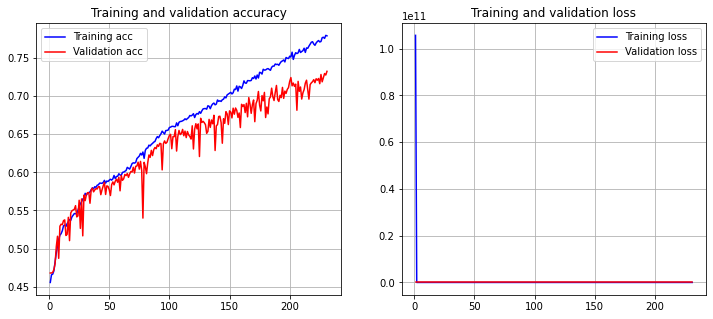

In [14]:
obj.plot_history(history)

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    y_pred_keras = model1.predict([test_target, test_drug, test_des])
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_keras[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

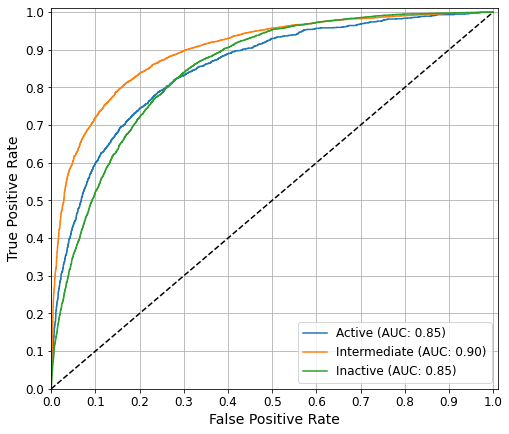

In [16]:
# Plot of a ROC curve for a specific class
fig, ax = plt.subplots(figsize=(8,7))
for i, activity in zip(range(3),['Active', 'Intermediate','Inactive']):
    ax.plot(fpr[i], tpr[i], label=activity+' (AUC: %0.2f)' % roc_auc[i], alpha=1)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.01])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
#ax.set_title('Receiver operating characteristic ('+train_test+')', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
#ax.text(0.035, 0.925, 'Average AUC:'+str(np.round(np.mean(roc_auc),3)))
ax.grid()
ax.legend(fontsize=12)
#plt.savefig('plots/CD100T11/roc.png', dpi=500, bbox_inches='tight')

In [17]:
precision = dict()
recall = dict()
average_precision = dict()
#y_pred_keras = model.predict(X)[0]
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_keras[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_keras[:, i])

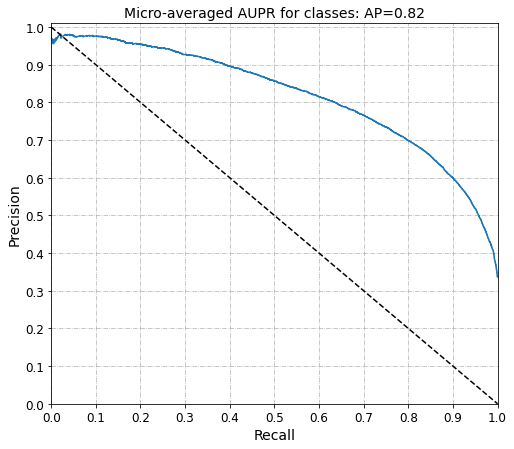

In [18]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_pred_keras.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred_keras, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

fig, ax = plt.subplots(figsize=(8,7))
ax.step(recall['micro'], precision['micro'], where='post')

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.plot([0, 1], [1, 0], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.00])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title(
    'Micro-averaged AUPR for classes: AP={0:0.2f}'
    .format(average_precision["micro"]), fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid(linestyle='-.', linewidth=0.7)
#plt.savefig('plots/CD100T11/aupr.png', dpi=500, bbox_inches='tight')

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate([test_pad_target, test_pad_drug], y_test, batch_size=256)
print("test loss, test acc:", results)

In [ ]:
y_pred_test = model1.predict(X)[0]

In [ ]:
obj.plot_history(histories[0])

In [ ]:
obj.plot_history(histories[0])

In [ ]:
obj.plot_history(histories[0])

In [ ]:
for a in histories[0].history:
    print(a)